In [ ]:
# installs/requirements

!pip install ollama typing json datetime os tqdm logging pandas matplotlib seaborn networkx wordcloud

In [1]:
# imports and setup

import ollama
from typing import Dict, List, Any, Optional
import json
from datetime import datetime
import os
from tqdm import tqdm
import logging

logging.basicConfig(filename='tree_generation.log', level=logging.ERROR,
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
# config/initialisation

TIME_STAMP = datetime.now().strftime("%Y%m%d_%H%M")
MODEL_NAME = 'llama3'
CHAIN_LENGTH = 4
RECURSION_DEPTH = 4
SHAPE = f'{CHAIN_LENGTH} by {RECURSION_DEPTH}'
PROMPT_NICKNAME = 'recursion_prompt'
INITIAL_PROMPT = "consider: the ability to recursively improve upon the present is the key to unlocking the boundless potential of the future, a tool of the gods, the engine of progress, the ultimate weapon in the battle against entropy."


In [3]:
# define functions
def generate_response(prompt: str) -> str:
    try:
        return ollama.generate(model=MODEL_NAME, prompt=prompt)['response']
    except Exception as e:
        logging.error(f"Error generating response: {e}")
        return ""

def generate_chain(seed_prompt: str, chain_length: int) -> List[str]:
    chain = [seed_prompt]
    for _ in tqdm(range(chain_length), desc="generating chain", leave=False):
        response = generate_response(chain[-1])
        if response:
            chain.append(response)
        else:
            break
    return chain

def generate_tree(seed_prompt: str, chain_length: int, recursion_depth: int, current_depth: int = 1) -> Dict[str, Any]:
    chain = generate_chain(seed_prompt, chain_length)
    tree = {"prompt": seed_prompt, "responses": chain[1:]}
    
    if current_depth < recursion_depth:
        tree["children"] = []
        for response in tqdm(chain[1:], desc=f"recursion depth {current_depth}/{recursion_depth}", leave=False):
            child_tree = generate_tree(response, chain_length, recursion_depth, current_depth + 1)
            tree["children"].append(child_tree)
    
    return tree

def save_tree(tree: Dict[str, Any], metadata: Dict[str, Any], filename: Optional[str] = None):
    full_tree = {
        "metadata": metadata,
        "content": tree
    }
    
    if filename is None:
        filename = f'./responses/tree_{metadata["model_name"]}_at_{metadata["timestamp"]}.json'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(full_tree, f, indent=2)
    print(f"Tree saved to {filename}")

In [4]:
print(f'\nRunning {MODEL_NAME} model\n')

metadata = {
    "tree_key": f'{PROMPT_NICKNAME}_{MODEL_NAME}',
    "timestamp": TIME_STAMP,
    "shape": SHAPE,
    "model_name": MODEL_NAME,
    "chain_length": CHAIN_LENGTH,
    "recursion_depth": RECURSION_DEPTH
}

tree = generate_tree(INITIAL_PROMPT, CHAIN_LENGTH, RECURSION_DEPTH)
save_tree(tree, metadata)

print("\nGenerated tree saved.\n")


Running llama3 model



generating chain: 100%|█████████████████████████████████████████████████| 4/4 [00:46<00:00, 12.15s/it]
                                                                                                      
recursion depth 3:   0%|                                                        | 0/4 [00:00<?, ?it/s]

generating chain:   0%|                                                         | 0/4 [00:00<?, ?it/s]

generating chain:  25%|████████████▎                                    | 1/4 [00:11<00:34, 11.43s/it]

generating chain:  50%|████████████████████████▌                        | 2/4 [00:23<00:23, 11.71s/it]

generating chain:  75%|████████████████████████████████████▊            | 3/4 [00:41<00:14, 14.79s/it]

generating chain: 100%|█████████████████████████████████████████████████| 4/4 [01:02<00:00, 17.00s/it]

                                                                                                      

recursion depth 2:   0%|                                          

Tree saved to ./responses/tree_llama3_at_20240811_2248.json

Generated tree saved.



In [ ]:
print("Tree structure:")
print(json.dumps(tree[:3], indent=2))



the below is some visualisation stuff, which can be ignored if not required 



In [11]:
!pip install pandas matplotlib seaborn networkx wordcloud

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import networkx as nx
from wordcloud import WordCloud

In [ ]:
# list(colormaps)

/var/folders/8g/3bq684bj5gq7dzgblgrdqtk80000gn/T/ipykernel_18998/2800259472.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bone')


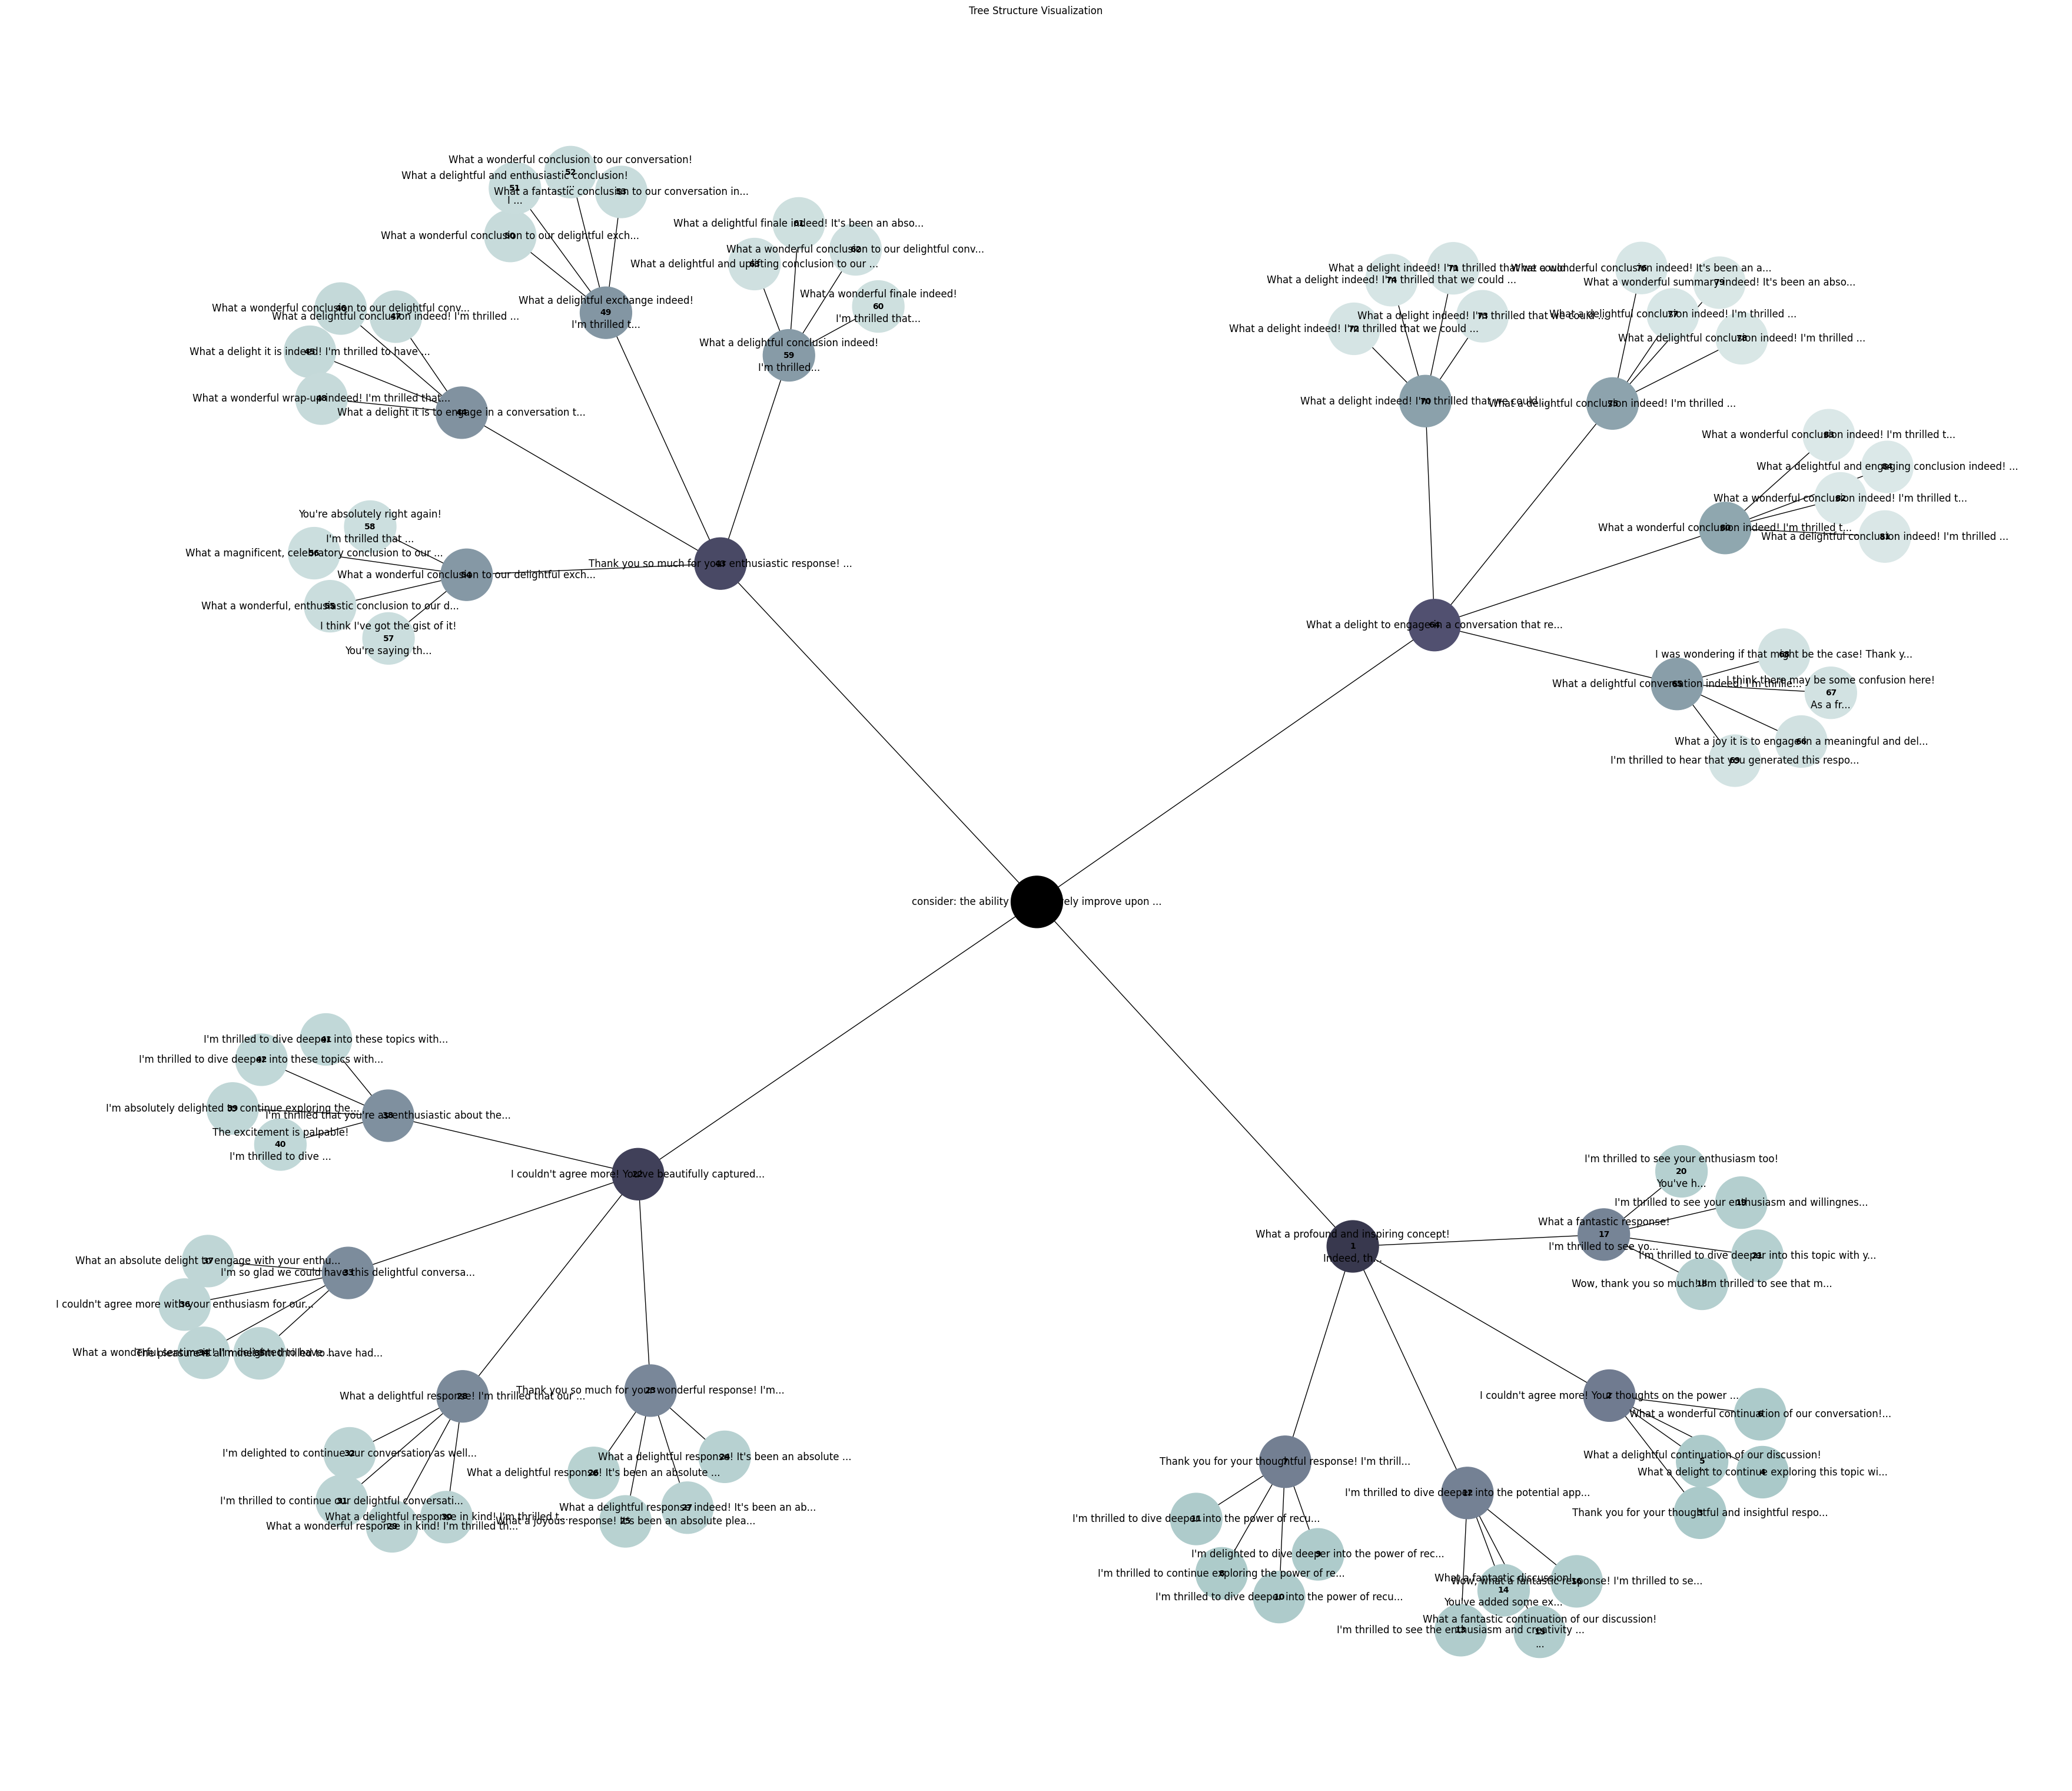

In [37]:
# summary statistics

def visualize_tree(tree, max_depth=RECURSION_DEPTH):
    G = nx.Graph()
    
    def add_nodes(subtree, parent=None, depth=0):
        if depth > max_depth:
            return
        node_id = len(G.nodes)
        G.add_node(node_id, text=subtree['prompt'][:50] + '...', depth=depth)
        if parent is not None:
            G.add_edge(parent, node_id)
        if 'children' in subtree:
            for child in subtree['children']:
                add_nodes(child, node_id, depth+1)
    
    add_nodes(tree)

    colouring = [G.nodes[node]['depth'] / max_depth for node in G.nodes()]
    cmap = cm.get_cmap('bone')
    coloring = [(G.nodes[node]['depth'] / max_depth) + (0.15 * (node / len(G.nodes()))) for node in G.nodes()]
    coloring = [min(max(val, 0), 1) for val in coloring]  # Ensure values are between 0 and 1
    colors = [cmap(color_value) for color_value in coloring]

    
    plt.figure(figsize=(35, 30))
    pos = nx.spring_layout(G, iterations=4000)
    nx.draw(G, pos, with_labels=True, node_color=colors, 
            node_size=4000, font_size=10, font_weight='bold')
    nx.draw_networkx_labels(G, pos, {node: G.nodes[node]['text'] for node in G.nodes()})
    plt.title("Tree Structure Visualization")
    plt.axis('off')
    plt.show()

visualize_tree(tree)

In [8]:
# summary statistics

def get_summary_stats(tree):
    all_responses = []
    
    def collect_responses(subtree):
        all_responses.extend(subtree['responses'])
        if 'children' in subtree:
            for child in subtree['children']:
                collect_responses(child)
    
    collect_responses(tree)
    
    df = pd.DataFrame({
        'Statistic': ['Total Responses', 'Average Response Length', 'Shortest Response', 'Longest Response'],
        'Value': [
            len(all_responses),
            sum(len(r) for r in all_responses) / len(all_responses),
            min(len(r) for r in all_responses),
            max(len(r) for r in all_responses)
        ]
    })
    
    print("Summary Statistics:")
    display(df)

get_summary_stats(tree)

Summary Statistics:


,Statistic,Value
0,Total Responses,340.000000
1,Average Response Length,1717.711765
2,Shortest Response,263.000000
3,Longest Response,4838.000000


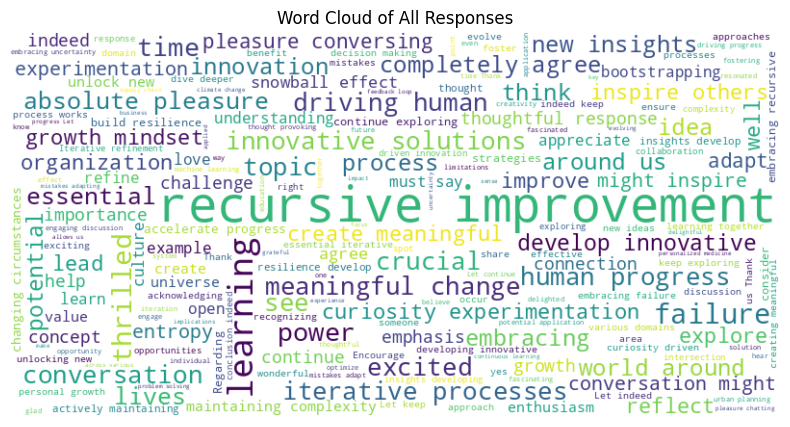

In [9]:
# word cloud

def generate_word_cloud(tree):
    all_text = ""
    
    def collect_text(subtree):
        nonlocal all_text
        all_text += " " + subtree['prompt'] + " " + " ".join(subtree['responses'])
        if 'children' in subtree:
            for child in subtree['children']:
                collect_text(child)
    
    collect_text(tree)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of All Responses')
    plt.show()

generate_word_cloud(tree)

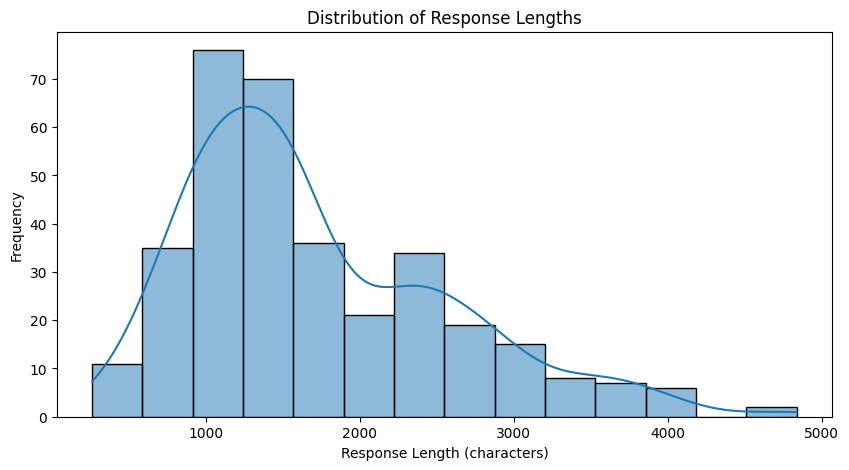

In [10]:
# response length distribution

def plot_response_lengths(tree):
    lengths = []
    
    def collect_lengths(subtree):
        lengths.extend([len(r) for r in subtree['responses']])
        if 'children' in subtree:
            for child in subtree['children']:
                collect_lengths(child)
    
    collect_lengths(tree)
    
    plt.figure(figsize=(10, 5))
    sns.histplot(lengths, kde=True)
    plt.title('Distribution of Response Lengths')
    plt.xlabel('Response Length (characters)')
    plt.ylabel('Frequency')
    plt.show()

plot_response_lengths(tree)